In [1]:
import torch
import torch.nn as nn
import os
import re
from pathlib import Path

# import gluonnlp
import numpy as np
from scipy import stats
import torch
import torch.nn as nn 

GPUIdx = "3"

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= GPUIdx

from tqdm.auto import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
from transformers import AutoTokenizer, AutoModel
Tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
Embedding = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
UNCASE = True

# FileObject = open("../../Data/DefinitionDataset/LexicoDefinition.txt", 'r', encoding='utf-8')
FileObject = open("./data/DefinitionDataset.txt", 'r', encoding='utf-8')
VocabDefExamDict = {}
MAX_SEQ_LEN = 512
pbar = tqdm(total = 1)
for line in FileObject:
    Contents = line.split(" (def.) ")
    Word = Contents[0].strip()
#     print(Word)
    if UNCASE: Word = Word.lower()
    ### Word -> Definition1 -> [ex1, ex2]
    Defs = {}
    for c in Contents[1:]:
        c = c.split(" (ex.)")
        Def = c[0].strip(); Examples = c[1].strip()
        if UNCASE:
            Def = Def.lower()
            Examples = Examples.lower()
            
        Examples = Examples.split(' | ')
        ### When don't know MAX_SEQ_LEN
#         SEQ_LEN =  max(*[len(Tokenizer.encode(e)) for e in Examples], len(Tokenizer.encode(Def)))
#         if SEQ_LEN > MAX_SEQ_LEN:
#             MAX_SEQ_LEN = SEQ_LEN
        Defs[Def] = Examples if len(Examples) else ''
    
    if Word in VocabDefExamDict.keys():
        VocabDefExamDict[Word].update(Defs)
    else:
        VocabDefExamDict[Word] = Defs
    pbar.update(1)
pbar.close()

MAX_SEQ_LEN = min(512, MAX_SEQ_LEN)
MAX_SEQ_LEN = max(256, MAX_SEQ_LEN)

print(len(VocabDefExamDict), MAX_SEQ_LEN)

  0%|          | 0/1 [00:00<?, ?it/s]

30533 512


In [4]:
print(f"{len(VocabDefExamDict.keys()) = }")
DefNum = []
DefSeqNum = []
for v in VocabDefExamDict.keys():
    DefNum += [ len(VocabDefExamDict[v]) ]
    DefSeqNum += [ len(d.split()) for d in VocabDefExamDict[v] ]
#     DefSeqNum += [len(d.split()) for d in VocabDefExamDict[k].keys()]
print(f"{np.sum(DefNum) = }")
print(f"{np.max(DefNum) = }")
print(f"{np.mean(DefSeqNum) = }")
# print(np.max(DefSeqNum))

ExamNum = []
ExamSeqNum = []
for v in VocabDefExamDict.keys():
    for d in VocabDefExamDict[v].keys():
        ExamNum += [ len(VocabDefExamDict[v][d]) ]
        ExamSeqNum += [ len(ex.split()) for ex in VocabDefExamDict[v][d] ]

print(f"{np.sum(ExamNum) = }")
print(f"{np.max(ExamNum) = }")
print(f"{np.mean(ExamSeqNum) = }")

len(VocabDefExamDict.keys()) = 30533
np.sum(DefNum) = 93227
np.max(DefNum) = 76
np.mean(DefSeqNum) = 10.503995623585443
np.sum(ExamNum) = 1171533
np.max(ExamNum) = 85
np.mean(ExamSeqNum) = 18.03715046865944


In [5]:
PAIR_list = ["Word-Word", "Word-Def", "Word-ExamWord", "Def-ExamWord"]
PAIR_cnt = dict(zip(PAIR_list, [0]*len(PAIR_list)))

WordDef_train_src, DefExam_train_src, WordExam_train_src = [], [], []
WordWord_train_src, WordExWord_train_src, DefExWord_train_src = [], [], []
WordDef_train_tgt, DefExam_train_tgt, WordExam_train_tgt = [], [], []
WordWord_train_tgt, WordExWord_train_tgt, DefExWord_train_tgt = [], [], []

### Saved Indices
for PAIR in PAIR_list:
    pbar = tqdm(total=len(VocabDefExamDict))
    for Word in VocabDefExamDict:
        if PAIR == "Word-Word":
            WordWord_train_src.append(Word+'|'+Word)
            WordWord_train_tgt.append(Word+'|'+Word)
            PAIR_cnt[PAIR] += 1
        
        elif PAIR == "Word-Def":
            Defs = list(VocabDefExamDict[Word].keys())
            for d in Defs:
                WordDef_train_src.append(Word+'|'+Word)
                WordDef_train_tgt.append(Word+'|'+d)
                PAIR_cnt[PAIR] += 1
                
        elif PAIR == "Word-ExamWord":
            w = VocabDefExamDict[Word]
            Defs = list(w.keys())
            for d in Defs:
                for ex in w[d]:
                    if ex != '':
                        WordExWord_train_src.append(Word+'|'+Word)
                        WordExWord_train_tgt.append(Word+'|'+ex)
                        PAIR_cnt[PAIR] += 1
                        
        elif PAIR == "Def-ExamWord":
            w = VocabDefExamDict[Word]
            Defs = list(w.keys())
            for d in Defs:
                for ex in w[d]:
                    if ex != '':
                        DefExWord_train_src.append(Word+'|'+d)
                        DefExWord_train_tgt.append(Word+'|'+ex)
                        PAIR_cnt[PAIR] += 1
        else:
            print("Out-of-Bound")
            break
        ### For Debug
#         break
        pbar.update(1)
    pbar.close()

  0%|          | 0/30533 [00:00<?, ?it/s]

  0%|          | 0/30533 [00:00<?, ?it/s]

  0%|          | 0/30533 [00:00<?, ?it/s]

  0%|          | 0/30533 [00:00<?, ?it/s]

In [6]:
from torch.utils.data import Dataset, DataLoader

class DefinitionDataset(Dataset):
    def __init__(self, x=None, y=None):
        self.x = x
        self.y = y
        self.len = len(self.x)
        self.token_config = {"truncation": True, "padding": "max_length",
                            "max_length": MAX_SEQ_LEN, "return_tensors": "pt"}
    def __getitem__(self, index):
        target_w = self.x[index].split('|')[0]
        x = self.x[index].split('|')[1]
        y = self.y[index].split('|')[1]
        w_tokenized = Tokenizer(target_w, add_special_tokens=False, padding="max_length",
                                max_length=10, return_tensors="pt")
        x_tokenized = Tokenizer(x, **self.token_config)
        y_tokenized = Tokenizer(y, **self.token_config)
        return w_tokenized, x_tokenized, y_tokenized
    
    def __len__(self):
        return self.len

In [7]:
import random

Hyperparams = {
    "NumEpochs": 10,
    "BatchSize": 2**7,
#     "BatchSize": 2**5,
#     "LearningRate": 2e-3,
    "LearningRate": 1e-5,
}

train_dataset_WordWord = DefinitionDataset(x=WordWord_train_src, y=WordWord_train_tgt) if len(WordWord_train_src) else None
train_dataset_WordDef = DefinitionDataset(x=WordDef_train_src, y=WordDef_train_tgt) if len(WordDef_train_src) else None
train_dataset_WordExWord = DefinitionDataset(x=WordExWord_train_src, y=WordExWord_train_tgt) if len(WordExWord_train_src) else None
train_dataset_DefExWord = DefinitionDataset(x=DefExWord_train_src, y=DefExWord_train_tgt)  if len(DefExWord_train_src) else None

train_loader_WordWord = DataLoader(dataset=train_dataset_WordWord, batch_size=Hyperparams["BatchSize"], shuffle=True, num_workers=0)
train_loader_WordDef = DataLoader(dataset=train_dataset_WordDef, batch_size=Hyperparams["BatchSize"], shuffle=True, num_workers=0)
train_loader_WordExWord = DataLoader(dataset=train_dataset_WordExWord, batch_size=Hyperparams["BatchSize"], shuffle=True, num_workers=0)
train_loader_DefExWord = DataLoader(dataset=train_dataset_DefExWord, batch_size=Hyperparams["BatchSize"], shuffle=True, num_workers=0)

print(len(WordWord_train_src), len(WordDef_train_src), len(WordExWord_train_src), len(DefExWord_train_src))

30533 93227 1167055 1167055


In [8]:
def DistanceChecker(word_token_ids, DistanceInfo, Emb1, Emb2):
    for b in range(word_token_ids.size(0)):
        w = Tokenizer.decode(word_token_ids[b], True)
        if w in DistanceInfo:
            DistanceInfo[w] += [crit_sum(Emb1[b], Emb2[b]).item()]
        else:
            DistanceInfo[w] = [crit_sum(Emb1[b], Emb2[b]).item()]
    return DistanceInfo

def get_emb(word_token_ids, EmbDict, Emb1, Emb2):
    for b in range(word_token_ids.size(0)):
#         print(word_token_ids[b])
        w = Tokenizer.decode(word_token_ids[b], True)
#         print(w)
#         print(EmbDict)
        if w in EmbDict.keys():
            EmbDict[w] += [ Emb2[b].cpu() ]
        else:
            EmbDict[w] = [ Emb2[b].cpu() ]
    return EmbDict

In [9]:
import copy
import random

crit_mean = nn.MSELoss()
crit_sum = nn.MSELoss(reduction='sum')
cos = nn.CosineSimilarity(dim=1, eps=1e-5)

In [40]:
from transformers import BertConfig, BertModel
### Training Seq
# PAIR_seq = ["Word-Def"]
PAIR_seq = ["Def-ExamWord"]

#####
### Initialization
# Embedding = AutoModel.from_pretrained('bert-base-uncased')
# Embedding_ = AutoModel.from_pretrained('bert-base-uncased')

### Random
configuration = BertConfig()
Embedding = BertModel(configuration)
Embedding_ = BertModel(configuration)

# Embedding = AutoModel.from_pretrained('./save/WordWord/3/')
# Embedding_ = AutoModel.from_pretrained('./save/WordWord/10/')
# Embedding = BertModel.from_pretrained("./save/2")
# Embedding_ = BertModel.from_pretrained("./save/WordExword/")
# Embedding = nn.DataParallel(Embedding).to(device)
# Embedding_ = nn.DataParallel(Embedding_).to(device)
#####
### Fine-tuning
Hyperparams["LearningRate"] = 1e-4
# Hyperparams["LearningRate"] = 0
# Hyperparams["LearningRate"] = 5e-6
# Hyperparams["LearningRate"] = 1e-6
Hyperparams["NumEpochs"] = 1
#####

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, Embedding.parameters()), lr=Hyperparams["LearningRate"])
pbar = tqdm(total=Hyperparams["NumEpochs"])

Embedding = nn.DataParallel(Embedding).to(device)
# Embedding_ = nn.DataParallel(Embedding).to(device)
Embedding_ = copy.deepcopy(Embedding) # Initializer

Extractor = torch.tensor([0]).unsqueeze(1).expand(-1,10).to(device)
MaxAvg = 0
EmbDict = {}
DistanceInfo = [{} for _ in range(13)]

for ep in range(Hyperparams["NumEpochs"]):
    random.shuffle(PAIR_list)
    Embedding.eval()    
    Embedding_ = copy.deepcopy(Embedding) # Copier / Epoch
    Embedding_.eval()

    for PAIR in PAIR_seq:
#         Embedding_ = copy.deepcopy(Embedding) # PAIR Copier
        ### Renew Optimizer
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, Embedding.parameters()), lr=Hyperparams["LearningRate"])
        print(PAIR, "in Training")
        if PAIR == "Word-Def":
            pbar2 = tqdm(total=len(train_dataset_WordDef), leave=True)
            for i, (w, x, y) in enumerate(train_loader_WordDef):
                w = { k: v[:,0,:].to(device) for k, v in w.items() }
                x = { k: v[:,0,:].to(device) for k, v in x.items() }
                y = { k: v[:,0,:].to(device) for k, v in y.items() }
                ### PAD
                idx = (y["input_ids"] == w["input_ids"][:,0].unsqueeze(1).expand(-1,MAX_SEQ_LEN)).nonzero()
                wlen = (w["input_ids"] != Extractor).sum(dim=1)
                for (xx, yy), wl in zip(idx, wlen):
                    for wl_idx in range(yy,yy+wl):
                        x["input_ids"][xx,wl_idx] = Tokenizer.pad_token_id # pad id
                
                with torch.no_grad(): OutEmb2 = Embedding_(**y, output_hidden_states=True)
                with torch.no_grad(): OutEmb1 = Embedding(**x, output_hidden_states=True)
                loss = 0
                ### W_t - D_[CLS]
#                 for (xx, yy), wl in zip(idx, wlen):
#                     loss += crit_sum(torch.mean(OutEmb1[0][xx,yy:yy+wl,:], dim=0), OutEmb2[0][xx,0,:])
#                     loss += crit_sum(OutEmb1[0][xx,0,:], torch.mean(OutEmb2[0][xx,yy:yy+wl,:], dim=0))
#                 loss /= x["input_ids"].size(0)
                ### W_[CLS] - D_[CLS]
                loss += crit_sum(OutEmb1[0][:,0,:], OutEmb2[0][:,0,:])
                EmbDict = get_emb(x["input_ids"], EmbDict, OutEmb1[0][:,0,:], OutEmb2[0][:,0,:])
                
                for H in range(13):
                    DistanceInfo[H] = DistanceChecker(x["input_ids"],
                            DistanceInfo[H], OutEmb1[2][H][:,0,:], OutEmb2[2][H][:,0,:])

                pbar2.update(x["input_ids"].size(0))
            pbar2.close()
        elif PAIR == "Word-Word": # Need to be Tuned
            pbar2 = tqdm(total=len(train_dataset_WordWord), leave=True)
            for i, (w, x, y) in enumerate(train_loader_WordWord):
                w = { k: v[:,0,:].to(device) for k, v in w.items() }
                x = { k: v[:,0,:].to(device) for k, v in x.items() }
                y = { k: v[:,0,:].to(device) for k, v in y.items() }
                with torch.no_grad(): OutEmb2 = Embedding_(**y)
                OutEmb1 = Embedding(**x)
                idx = (y["input_ids"] == w["input_ids"][:,0].unsqueeze(1).expand(-1,MAX_SEQ_LEN)).nonzero()
                wlen = (w["input_ids"] != Extractor).sum(dim=1)
                ###
                loss = 0
                for (xx, yy), wl in zip(idx, wlen):
                    ### W_[CLS] - W_t / W_t - W_[CLS]
                    loss += crit_sum(OutEmb1[0][xx,0,:], torch.mean(OutEmb2[0][xx,yy:yy+wl,:], dim=0)) # Target
#                     loss += crit_sum(torch.mean(OutEmb1[0][xx,yy:yy+wl,:], dim=0), OutEmb2[0][xx,0,:])
                loss /= x["input_ids"].size(0)#*2
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                pbar2.update(x["input_ids"].size(0))
            pbar2.close()
            
        elif PAIR == "Word-ExamWord":
            pbar2 = tqdm(total=len(train_dataset_WordExWord), leave=True)
            for i, (w, x, y) in enumerate(train_loader_WordExWord):
                w = { k: v[:,0,:].to(device) for k, v in w.items() }
                x = { k: v[:,0,:].to(device) for k, v in x.items() }
                y = { k: v[:,0,:].to(device) for k, v in y.items() }
                with torch.no_grad(): OutEmb2 = Embedding_(**y)
                with torch.no_grad(): OutEmb1 = Embedding(**x)
                idx = (y["input_ids"] == w["input_ids"][:,0].unsqueeze(1).expand(-1,MAX_SEQ_LEN)).nonzero()
                wlen = (w["input_ids"] != Extractor).sum(dim=1)
#                 wlen = wlen - SpTokenCnt
                loss = 0
                for (xx, yy), wl in zip(idx, wlen):
                    loss += crit_sum(OutEmb1[0][xx,0,:], torch.mean(OutEmb2[0][xx,yy:yy+wl,:], dim=0))
                loss /= x["input_ids"].size(0)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                pbar2.update(x["input_ids"].size(0))
            pbar2.close()
            
        elif PAIR == "Def-ExamWord":
            pbar2 = tqdm(total=len(train_dataset_DefExWord), leave=True)
            for i, (w, x, y) in enumerate(train_loader_DefExWord):
                w = { k: v[:,0,:].to(device) for k, v in w.items() }
                x = { k: v[:,0,:].to(device) for k, v in x.items() }
                y = { k: v[:,0,:].to(device) for k, v in y.items() }
                ##### Def->ExamWord
                idx = (y["input_ids"] == w["input_ids"][:,0].unsqueeze(1).expand(-1,MAX_SEQ_LEN)).nonzero()
                wlen = (w["input_ids"] != Extractor).sum(dim=1)
                ### PAD
#                 for (xx, yy), wl in zip(idx, wlen):
#                     for wl_idx in range(yy,yy+wl):
#                         x["input_ids"][xx,wl_idx] = Tokenizer.pad_token_id # pad id
                        
                with torch.no_grad(): OutEmb2 = Embedding_(**y, output_hidden_states=True)
                with torch.no_grad(): OutEmb1 = Embedding(**x, output_hidden_states=True)

                for (xx, yy), wl in zip(idx, wlen):
                    EmbDict = get_emb(w["input_ids"][xx], EmbDict, OutEmb1[0][xx,0,:], torch.mean(OutEmb2[0][xx,yy:yy+wl,:], dim=0))
                    
                for H in range(13):
                    for (xx, yy), wl in zip(idx, wlen):
                        DistanceInfo[H] = DistanceChecker(w["input_ids"][xx],
                                DistanceInfo[H], OutEmb1[2][H][xx,0,:], torch.mean(OutEmb2[2][H][xx,yy:yy+wl,:], dim=0))

                loss = 0
#                 for (xx, yy), wl in zip(idx, wlen):
#                     loss += crit_sum(OutEmb1[0][xx,0,:], torch.mean(OutEmb2[0][xx,yy:yy+wl,:], dim=0))
#                 loss /= x["input_ids"].size(0)
#                 optimizer.zero_grad()
#                 if len(idx): loss.backward()
#                 optimizer.step()
                pbar2.update(x["input_ids"].size(0))
            pbar2.close()
            
                ### ExamWord->Def
#                 with torch.no_grad(): OutEmb2 = Embedding_(x)
#                 OutEmb1 = Embedding(y)
#                 idx = (y == Word[:,0].unsqueeze(1).expand(x.size(0),MAX_SEQ_LEN)).nonzero()
#                 loss = 0
#                 for xx, yy in idx:
#                     loss += crit(OutEmb1[1][xx], OutEmb2[0][xx,yy])
#                 optimizer.zero_grad()
#                 if len(idx):
# #                     loss = loss/len(idx)
#                     loss.backward()
#                 optimizer.step()
#                 pbar2.update(Hyperparams["BatchSize"])

        else:
            print("Unknown")
#             loss = crit_mean(OutEmb1[1], OutEmb2[1])
        break

        print("WordSim Scoring")
        ScoreList = []
        ScoreList.append(Evaluation(Embedding, Tokenizer, wordsim_sim))
        ScoreList.append(Evaluation(Embedding, Tokenizer, wordsim_rel))
        ScoreList.append(Evaluation(Embedding, Tokenizer, rw))
        ScoreList.append(Evaluation(Embedding, Tokenizer, men))
        ScoreList.append(Evaluation(Embedding, Tokenizer, sem))
        ScoreList.append(Evaluation(Embedding, Tokenizer, simlex))
        ScoreList.append(Evaluation(Embedding, Tokenizer, simverb))

        print('WordSim353(Sim) Score {:.3f}'.format(ScoreList[0]))
        print('WordSim353(Rel) Score {:.3f}'.format(ScoreList[1]))
        print('RareWords Score {:.3f}'.format(ScoreList[2]))
        print('MEN Score {:.3f}'.format(ScoreList[3]))
        print('SEM Score {:.3f}'.format(ScoreList[4]))
        print('SimLex Score {:.3f}'.format(ScoreList[5]))
        print('SimVerb Score {:.3f}'.format(ScoreList[6]))
        
        Avg = sum(ScoreList)/len(ScoreList)
        print("Average {:.3f}".format(Avg))
#         if Avg > MaxAvg:
        if False:
            MaxAvg = Avg
            print("=====New Best=====")
#             save_dir = Path('./save/'+GPUIdx)
            save_dir = Path('./save/4,5')
            save_dir.mkdir(parents=True, exist_ok=True)
            save_dir = str(save_dir)
            print("save to", save_dir)
            Embedding.module.save_pretrained(save_dir)
            Tokenizer.save_vocabulary(save_dir)

    pbar.update(1)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(ep+1, Hyperparams["NumEpochs"], loss))
#     Embedding.module.save_pretrained('./save')
    pbar2.close()
    
pbar.close()

  0%|          | 0/1 [00:00<?, ?it/s]

Def-ExamWord in Training


  0%|          | 0/1167055 [00:00<?, ?it/s]

Epoch [1/1], Loss: 0.0000


In [30]:
# file_object = open("./data/DefinitionDatasetNoPOS", 'r')
# file_object_save = open("./data/DefinitionDataset.txt", 'w')
# for line in file_object:
#     line = line.replace("?s=t", "")
#     file_object_save.write(line+'\n')
# file_object.close()
# file_object_save.close()

In [24]:
torch.save(EmbDict, "./EmbDict_WordDef_RAND")
# torch.save(EmbDict, "./EmbDict_DefExam_RAND")

In [37]:
### Def-Exam Distance RAND 1
for H in range(1,13):
    min_dist = 999
    sum_all_dist = 0
    for w, dist in DistanceInfo[H].items():
        avg_dist = sum(dist)/len(dist)
        sum_all_dist += avg_dist
    print(H, sum_all_dist/len(DistanceInfo[H]))

1 1.2543211751517773
2 1.2638335425796283
3 0.9773478116506843
4 0.7725217314072341
5 0.6072246747964998
6 0.8528065850321551
7 0.6343174118648629
8 0.4829244256959527
9 0.45362977126024195
10 0.40372587081429356
11 0.48853971951530906
12 0.4757216554282784


In [39]:
### Def-Exam Distance RAND 2
for H in range(1,13):
    min_dist = 999
    sum_all_dist = 0
    for w, dist in DistanceInfo[H].items():
        avg_dist = sum(dist)/len(dist)
        sum_all_dist += avg_dist
    print(H, sum_all_dist/len(DistanceInfo[H]))

1 1.1733561349957813
2 1.3116480552845844
3 1.002281553688338
4 1.0779085986418688
5 0.9565064874921038
6 0.6163931338661927
7 0.4505973655615372
8 0.8690953342517127
9 0.8355183627509223
10 0.7947626449801649
11 0.5770187012768524
12 0.5219582722484121


In [41]:
### Def-Exam Distance RAND 3
for H in range(1,13):
    min_dist = 999
    sum_all_dist = 0
    for w, dist in DistanceInfo[H].items():
        avg_dist = sum(dist)/len(dist)
        sum_all_dist += avg_dist
    print(H, sum_all_dist/len(DistanceInfo[H]))

1 0.7326491289541862
2 0.6853141141925196
3 0.6547279111776305
4 0.5059181033814302
5 0.5191443220897355
6 0.7939586849523057
7 0.7217189860666418
8 0.5859106014403027
9 0.644556851164505
10 0.697029170209102
11 0.5981916218203809
12 0.8048020719433202


In [14]:
### Word-Def Distance
for H in range(1,13):
    min_dist = 999
    sum_all_dist = 0
    for w, dist in DistanceInfo[H].items():
        avg_dist = sum(dist)/len(dist)
        sum_all_dist += avg_dist
    print(H, sum_all_dist/len(DistanceInfo[H]))

1 21.66948614551624
2 20.083015745026763
3 26.344259188643544
4 58.49017227219378
5 95.12900345927366
6 163.2929380736657
7 228.40180257732462
8 190.95525999435924
9 222.90461204805766
10 252.55388575573417
11 194.14743431997798
12 125.30955049808328


In [21]:
# Word-Def PAD
for H in range(1,13):
    min_dist = 999
    sum_all_dist = 0
    for w, dist in DistanceInfo[H].items():
        avg_dist = sum(dist)/len(dist)
        sum_all_dist += avg_dist
    print(H, sum_all_dist/len(DistanceInfo[H]))

1 21.69963761005995
2 20.167394277845297
3 26.42279852382098
4 58.559346936600456
5 95.99472710964142
6 166.27524067334707
7 231.18334458559747
8 194.00057537132537
9 225.56901953923068
10 256.38444129558803
11 198.84849264535646
12 128.95634983329313


In [25]:
### Rand Word-Def Distance
for H in range(1,13):
    min_dist = 999
    sum_all_dist = 0
    for w, dist in DistanceInfo[H].items():
        avg_dist = sum(dist)/len(dist)
        sum_all_dist += avg_dist
    print(H, sum_all_dist/len(DistanceInfo[H]))

1 12.118774129325503
2 25.532559345476976
3 39.00931031685391
4 52.48793635443836
5 62.12767735438507
6 69.7017019645351
7 84.69585853376853
8 96.09143156714373
9 106.424931867933
10 115.64847009309509
11 127.76806031646883
12 130.63714239240124


In [28]:
### Rand Word-Def Distance 2
for H in range(1,13):
    min_dist = 999
    sum_all_dist = 0
    for w, dist in DistanceInfo[H].items():
        avg_dist = sum(dist)/len(dist)
        sum_all_dist += avg_dist
    print(H, sum_all_dist/len(DistanceInfo[H]))

1 11.82391733855214
2 23.691717355302295
3 34.58949032346841
4 43.052798910535486
5 52.59142006117078
6 65.0449273196841
7 72.94565258581797
8 83.9560776559611
9 91.96689212375352
10 101.71599504427033
11 106.19051321141765
12 120.22365086723437


In [31]:
### Rand Word-Def Distance 3
for H in range(1,13):
    min_dist = 999
    sum_all_dist = 0
    for w, dist in DistanceInfo[H].items():
        avg_dist = sum(dist)/len(dist)
        sum_all_dist += avg_dist
    print(H, sum_all_dist/len(DistanceInfo[H]))

1 10.504775944188054
2 21.3879058150344
3 31.546087508352734
4 42.287389416124604
5 52.19274715428652
6 67.69038928026357
7 78.72876368277295
8 88.74481806805088
9 106.2796790249445
10 115.63460998375095
11 128.4339798107121
12 136.9016999791391


In [33]:
### Rand Word-Def Distance 4
for H in range(1,13):
    min_dist = 999
    sum_all_dist = 0
    for w, dist in DistanceInfo[H].items():
        avg_dist = sum(dist)/len(dist)
        sum_all_dist += avg_dist
    print(H, sum_all_dist/len(DistanceInfo[H]))

1 12.13240026435094
2 24.816727374741923
3 36.517722959574435
4 49.00234788379107
5 62.85176786277447
6 73.13500896685336
7 81.84614768943058
8 94.28537728982623
9 103.23447284796141
10 103.80378819010168
11 111.34635838351649
12 120.56315112920727


In [35]:
### Rand Word-Def Distance 5
for H in range(1,13):
    min_dist = 999
    sum_all_dist = 0
    for w, dist in DistanceInfo[H].items():
        avg_dist = sum(dist)/len(dist)
        sum_all_dist += avg_dist
    print(H, sum_all_dist/len(DistanceInfo[H]))

1 11.059659387412744
2 22.569080071275216
3 32.7913857970303
4 41.378892682109026
5 51.09083836125403
6 60.67514811740112
7 68.40467421595082
8 79.01093954227858
9 87.01617947368467
10 94.68038251690281
11 99.39400888913183
12 112.57802144382151


In [ ]:
### Rand Def-Exam Distance
for H in range(1,13):
    min_dist = 999
    sum_all_dist = 0
    for w, dist in DistanceInfo[H].items():
        avg_dist = sum(dist)/len(dist)
        sum_all_dist += avg_dist
    print(H, sum_all_dist/len(DistanceInfo[H]))

In [18]:
for H in range(1,13):
    min_dist = 999
    for w, dist in DistanceInfo[H].items():
        avg_dist = sum(dist)/len(dist)
        if avg_dist < min_dist:
            min_w = w
            min_dist = avg_dist
    print(H, min_w, min_dist)

1 corp. 0.40642428398132324
2 corp. 0.7480358779430389
3 corp. 1.1436077654361725
4 corp. 3.588529109954834
5 easy - to - use 11.066059112548828
6 corp. 23.287181854248047
7 shaven 69.07918548583984
8 shaven 65.34140014648438
9 shaven 68.60640716552734
10 shaven 77.46115112304688
11 shaven 61.61341094970703
12 also 12.283834457397461


In [31]:
torch.save(EmbDict, "./EmbDict_WordDef_PAD")

In [15]:
EmbDict = torch.load("./EmbDict")
import seaborn as sns
from tqdm.notebook import tqdm
sns.set(style="whitegrid")
x_axis, y_axis, x_axis_target, y_axis_target = [], [], [], []
pbar = tqdm(total = len(EmbDict))
idx = 0

import torch.nn as nn
crit_sum = nn.MSELoss(reduction='sum')
token_config = {"truncation": True, "padding": "max_length",
                            "max_length": MAX_SEQ_LEN, "return_tensors": "pt"}
TargetWords = ["love"]
Word = Tokenizer(TargetWords, **token_config)
# Word = torch.tensor(CLS_id + Word + SEP_id + PAD_id*(MAX_SEQ_LEN-SpTokenCnt-len(Word))).reshape(1,-1).long()
Embedding = AutoModel.from_pretrained('bert-base-uncased')
# Embedding = nn.DataParallel(Embedding).to(device)
# Embedding = Embedding.cpu()
with torch.no_grad(): OutEmb1 = Embedding(**Word, output_hidden_states=True)

MinDist, MaxDist = 999, 0
MinWord, MaxWord = '', ''
for w, ds in EmbDict.items():
    for i, d1 in enumerate(ds):
        x_axis.append(w)
        Dist = crit_sum(d1, OutEmb1[2][-1][:,0,:])
        
        if MinDist > Dist:
            MinDist = Dist
            MinWord = w
        elif MaxDist < Dist:
            MaxDist = Dist
            MaxWord = w
        if w in TargetWords:
            x_axis_target += [w]#*1000
            y_axis_target += [np.around(Dist, 3)]#*1000
#         else:
#             y_axis_target.append(0)
        y_axis.append(np.around(Dist, 3))
    
    pbar.update(1)
pbar.close()
x_axis = np.array(x_axis)
y_axis = np.array(y_axis)
y_axis_target = np.array(y_axis_target)

  0%|          | 0/30533 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 768])) that is different to the input

In [16]:
# DistanceInfo = {}
# for k, v in WordDistancesDict.items():
#     if len(v) >= 3:
#         DistanceInfo[k] = v

print("Variance High")
# DistanceInfo = dict(WordDistancesDict)
DistanceInfo = sorted(DistanceInfo.items(), key=lambda x: np.std(x[1]), reverse=True)
for i, d in enumerate(DistanceInfo):
    print(i, d[0], np.round(np.std(d[1]),2))
    if i == 10:
        break
print("Variance Low")
DistanceInfo = dict(DistanceInfo)
DistanceInfo = sorted(DistanceInfo.items(), key=lambda x: np.std(x[1]), reverse=False)
for i, d in enumerate(DistanceInfo):
    print(i, d[0], np.round(np.std(d[1]),2))
    if i == 10:
        break
print("Mean High")
DistanceInfo = dict(DistanceInfo)
DistanceInfo = sorted(DistanceInfo.items(), key=lambda x: np.sum(x[1])/len(x[1]), reverse=True)
for i, d in enumerate(DistanceInfo):
#     print(i, d[0], np.round(np.var(d[1]),2))
    print(i, d[0], np.round(np.mean(d[1]),2))
    if i == 10:
        break
print("Mean Low")
DistanceInfo = dict(DistanceInfo)
DistanceInfo = sorted(DistanceInfo.items(), key=lambda x: np.sum(x[1])/len(x[1]), reverse=False)
for i, d in enumerate(DistanceInfo):
#     print(i, d[0], np.round(np.var(d[1]),2))
    print(i, d[0], np.round(np.mean(d[1]),2))
    if i == 10:
        break

Variance High


AttributeError: 'list' object has no attribute 'items'

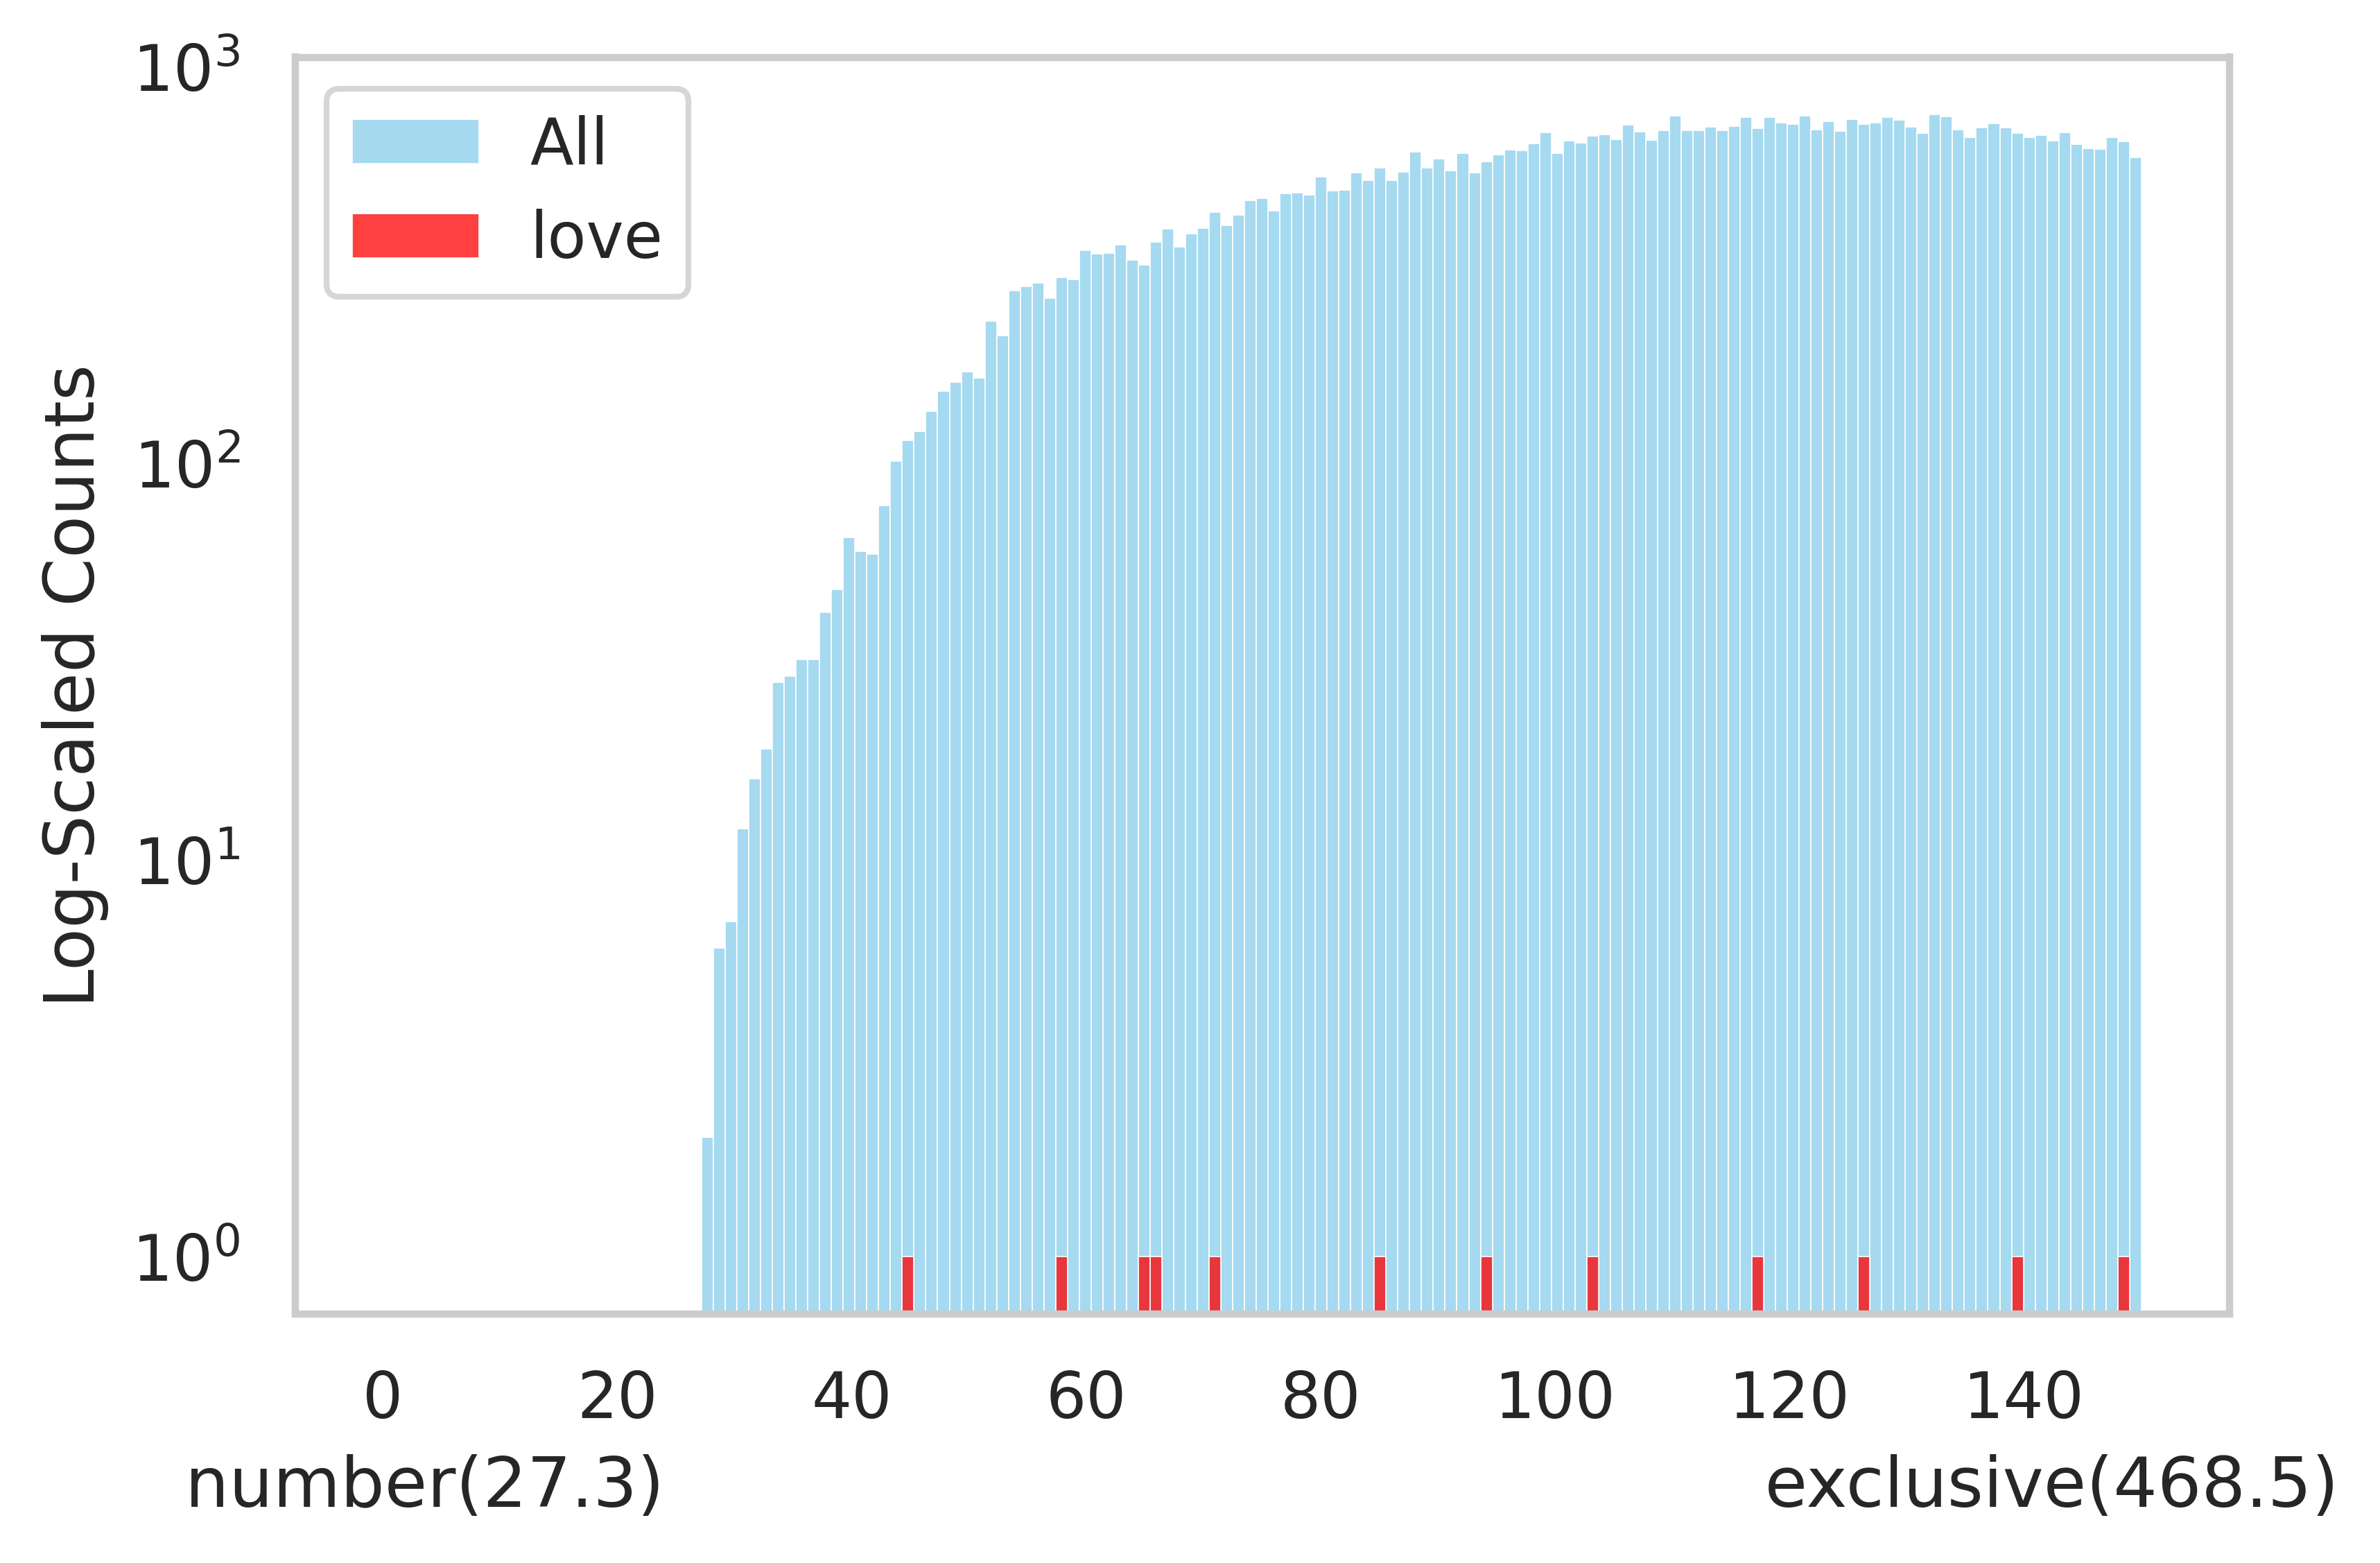

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(dpi=600)
bins = np.linspace(0, 150, 150)
ax = sns.histplot(data=y_axis, color='skyblue', bins=bins)
ax.set(yscale="log")
# ax.twinx()
bx = sns.histplot(data=y_axis_target, palette='bright', color='red', bins=bins)
# bx.set(yscale="log")
ax.grid(None)
# bx.grid(None)
ax.set_xlabel(str(MinWord)+'('+str(np.round(MinDist.item(),1))+')                                                  '
              +str(MaxWord)+'('+str(np.round(MaxDist.item(),1))+')', fontsize=12)

ax.set_ylabel("Log-Scaled Counts")
plt.legend(labels=['All', str(TargetWords[0])])
# bx.set_ylabel("Target Word Counts", rotation=270, rotation_mode='anchor', loc='center', labelpad=20)
# bx.set_yticks([1,2,3])
# bx.margins(5)
# bx.figure.subplots_adjust(right = 0.5)
# bx.margins(2)
# ax.set_title("Distances Distribution from '"+TargetWords[0]+"'", fontsize=14)
# ax.tick_params(labelsize=12)

In [31]:
file_object = open("./data/DefinitionDataset_.txt", 'r')
file_object_write = open("./data/DefinitionDataset.txt", 'w')
for line in file_object:
    line = line.strip()
    if line != "":
        file_object_write.write(line+'\n')
file_object.close()
file_object_write.close()